# Image classification with transfer learning and fine-tuning

*Disclaimer*: This notebook is a combination of several Tensorflow tutorials:
 - [Image classification](https://www.tensorflow.org/tutorials/images/classification)
 - [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)
 -[Tensorflow datasets: Keras exemple](https://www.tensorflow.org/datasets/keras_example)

Tensorflow documentation is released under a [CC 4.0 BY license](https://creativecommons.org/licenses/by/4.0/) with code samples under the [Apache 2.0 licence](https://www.apache.org/licenses/LICENSE-2.0)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


## Dataset
In this tutorial, you will use a dataset containing images on cats and dogs. It is part of a practice ML challenge proposed on the [Kaggle platform](https://www.kaggle.com/c/dogs-vs-cats).


We are going to acces it using the acessory library `tensorflow_datasets`. It provides many utilities for loading and acessing [several datasets](https://www.tensorflow.org/datasets/catalog/overview), incliding [the one we'll use here](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs).



In [ ]:
import tensorflow_datasets as tfds

Use `tfds.builder('data_set_handle_name').info` to get a data structure containing details about the dataset:

In [ ]:
data_info = tfds.builder('cats_vs_dogs').info
data_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

Our class labels are `cat` (0) and `dog` (1) : we are working on a binary classification problem.

In [ ]:
class_names = ['cat', 'dog']

In [ ]:
n_classes = len(class_names)
n_classes

2

### Data (down)loading

The `tfds.load` function will donwload and extract a zip file containing all the images, then create a `tf.data.Dataset` for training and validation. 

If you want to know more about the `tfds.load` function specifically, check its help and also these sections of the documentation:
  - [TFDS: Load data](https://www.tensorflow.org/datasets/overview#load_a_dataset)
  - [TFDS: Splits and Slicing](https://www.tensorflow.org/datasets/splits)

You can learn more about loading images in general in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).


In [ ]:
?tfds.load

We are goint to use the following arguments:
  - `shuffle_files=True`: for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
  - `as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [ ]:
train_dataset, validation_dataset , test_dataset = tfds.load(
    'cats_vs_dogs', 
    shuffle_files=True,
    as_supervised=True,
    split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'])


Let's check the size of all these splits using the method `cardinality`:

In [ ]:
train_dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=13957>

In [ ]:
# do the same for the other splits
validation_dataset.cardinality(), test_dataset.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=4653>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4652>)

`tfds` also provides us some visualization utility functions:

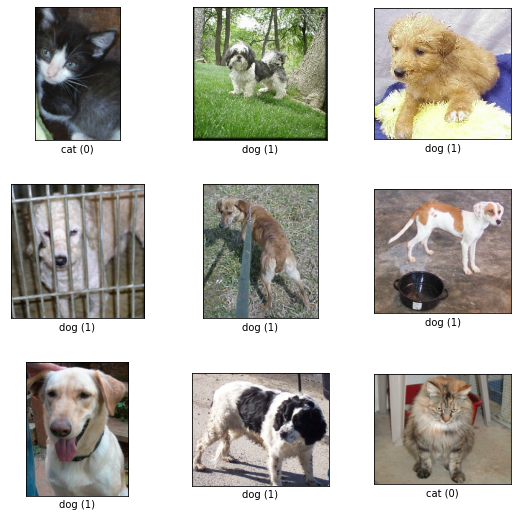

In [ ]:
tfds.visualization.show_examples(train_dataset, data_info);

We can check the structure of the individual dataset elements by reading one sample using the method `take(1)`:

In [ ]:
for element in train_dataset.take(1):
    print(element)

(<tf.Tensor: shape=(421, 484, 3), dtype=uint8, numpy=
array([[[  9,  10,   2],
        [  8,   9,   1],
        [  8,   9,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  9,  10,   2],
        [  8,   9,   1],
        [  8,   9,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  9,  10,   2],
        [  8,   9,   1],
        [  8,   9,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[167, 161, 149],
        [157, 151, 139],
        [161, 155, 143],
        ...,
        [241,  79,  41],
        [241,  79,  41],
        [237,  75,  37]],

       [[166, 160, 148],
        [156, 150, 138],
        [160, 154, 142],
        ...,
        [237,  75,  37],
        [237,  75,  37],
        [232,  70,  32]],

       [[166, 160, 148],
        [156, 150, 138],
        [160, 154, 142],
        ...,
        [237,  75,  

**Note**: The dataset is a python `iterable`. We can also extract elements by converting it to and `iterator` then calling `next` on it:

In [ ]:
element = next(iter(train_dataset))
element

(<tf.Tensor: shape=(480, 307, 3), dtype=uint8, numpy=
 array([[[ 14,  15,   7],
         [ 13,  14,   6],
         [ 12,  13,   5],
         ...,
         [ 92,  70,  56],
         [ 96,  70,  57],
         [ 90,  64,  51]],
 
        [[ 14,  15,   7],
         [ 13,  14,   6],
         [ 12,  13,   5],
         ...,
         [ 93,  72,  55],
         [ 97,  74,  58],
         [ 96,  73,  57]],
 
        [[ 16,  15,  10],
         [ 15,  14,   9],
         [ 14,  13,   8],
         ...,
         [ 98,  80,  60],
         [105,  84,  63],
         [104,  83,  62]],
 
        ...,
 
        [[217, 232, 211],
         [217, 232, 211],
         [216, 231, 210],
         ...,
         [180, 198, 208],
         [182, 201, 208],
         [184, 203, 210]],
 
        [[216, 231, 210],
         [216, 231, 210],
         [216, 229, 209],
         ...,
         [178, 198, 207],
         [179, 199, 206],
         [181, 201, 208]],
 
        [[214, 229, 208],
         [214, 229, 208],
         [214,

Here is an example plotting the first 9 images and labels from the training set:

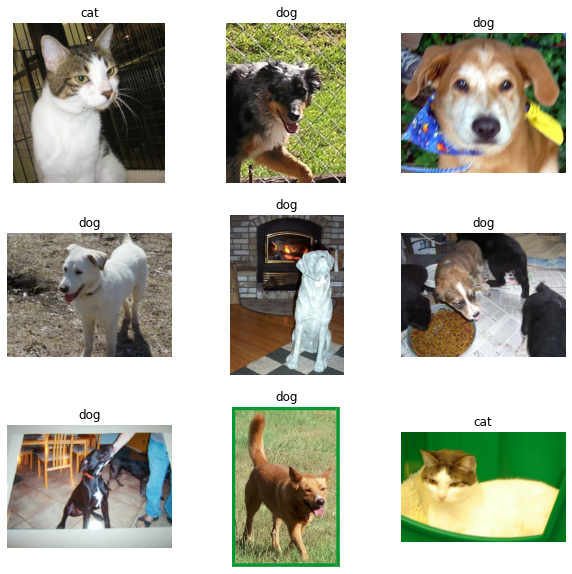

In [ ]:
plt.figure(figsize=(10, 10))
for i, element in enumerate(train_dataset.take(9)):
    image, label = element
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")

### Checking class distribution across splits
We have split the dataset into three partitions.
For large enough datasets, if the samples are aranged in random order, this should give us splits with similar class distributions. 
Here we will verify that this was indeed the case:


In [ ]:
labels = []

for i, ds in enumerate([train_dataset, validation_dataset, test_dataset]):
    labels.append([])
    for element in ds:
        iamge, label = element
        labels[i].append(label.numpy())

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


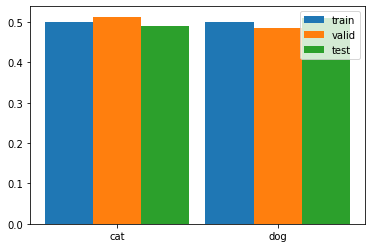

In [ ]:
plt.hist(labels, bins=np.arange(n_classes+1), density=True, 
         align='left', rwidth=0.90, label=['train', 'valid', 'test']);
plt.xticks(ticks=np.arange(n_classes), labels=class_names)

plt.legend()

### Preparing our [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) reading pipelines
`tf.data.Dataset` allows us to dynamically transform and load mini-batches of data in various ways. 
To do so, there are built-in methods we can call on a `tf.data.Dataset` like:  
  - `cache()`: keep a cache in memory of the most recently loaded elements. This helps to speed-up data loading during training.
  - `map(function)`: apply `function` to elements of the dataset before loading. We are going to use it here to resize all images to the same size before batching.
  - `shuffle(1000)`: create a buffer of 1000 elements and shuffle them before loading an element.  For true randomness, set the shuffle buffer to the full dataset size. For large datasets that can't fit in memory, use buffer_size=1000 if your system allows it.
  - `batch(32)`: load data in mini-batches of 32 samples
  - `prefetch(tf.data.AUTOTUNE)`: use buffered prefetching to load images from disk without having I/O become blocking. `tf.data.AUTOTUNE` will automatically set the buffer size. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

We will use these to create data feeding pipelines for training and evaluation (validation and testing).


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
def resize_image(images, labels):
    images = tf.image.resize(images, IMG_SIZE)
    return images, labels


#### Training pipeline

In [ ]:
train_dataset = train_dataset.map(resize_image).cache().shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

See how now all images have the same size and how each element retrieved from the dataset is a mini-batch of 32 images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

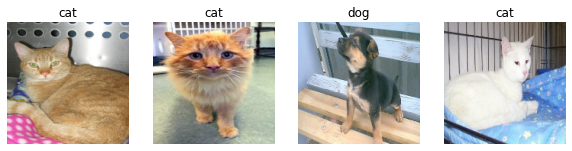

In [ ]:
plt.figure(figsize=(10, 10))
for image, label in train_dataset:
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")
    break

#### Evaluation pipelines

In [ ]:
# do the same for validation_split and test_split (you don't need to apply shuffling here)
validation_dataset = validation_dataset.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_image).batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.

Let's repeatedly apply these layers to the same image and see the result.

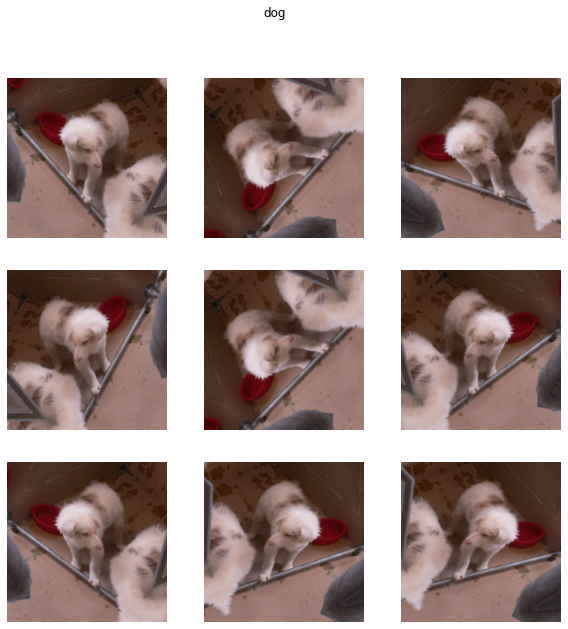

In [ ]:
plt.figure(figsize=(10, 10))
# take a batch
images, labels = next(iter(train_dataset))
# take first image to apply data augmentation
first_image = images[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    ax.imshow(augmented_image[0] / 255.)
    plt.axis('off')
    plt.suptitle(class_names[labels[0]])


### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.



### Checking how the model performs on our images
The `preprocess_input` function does not work directly on image batches (as the ones loaded by our tf.data.Dataset). We will have to include this function as part of a keras model. To declare this model it will be simpler to use the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_full = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
# just declare a series of operations
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
outputs = base_model_full(x)
# then build a model connecting the start and end points of your processing pipeline
imagenet_model = keras.Model(inputs=inputs, outputs=outputs)

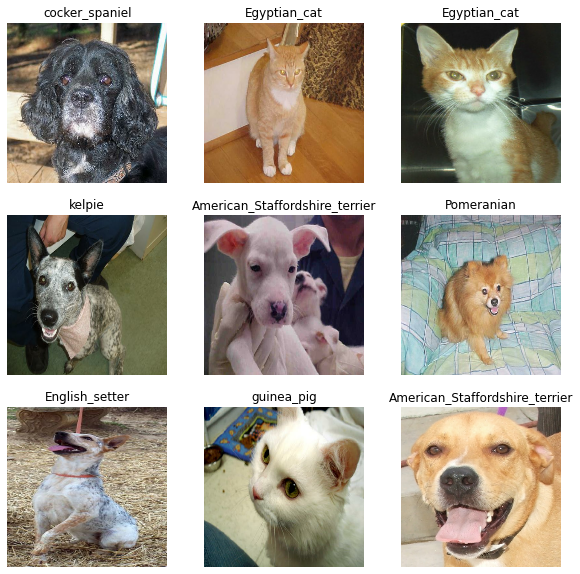

In [ ]:
plt.figure(figsize=(10, 10))
# take a batch
image, label = next(iter(train_dataset))
# compute prdictions
predictions = imagenet_model.predict(image)
# decode predicitons
pred_decod = keras.applications.mobilenet_v2.decode_predictions(predictions, top=1)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(pred_decod[i][0][1])
    plt.axis("off")



### Loading the pre-trained model without its top layer
First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


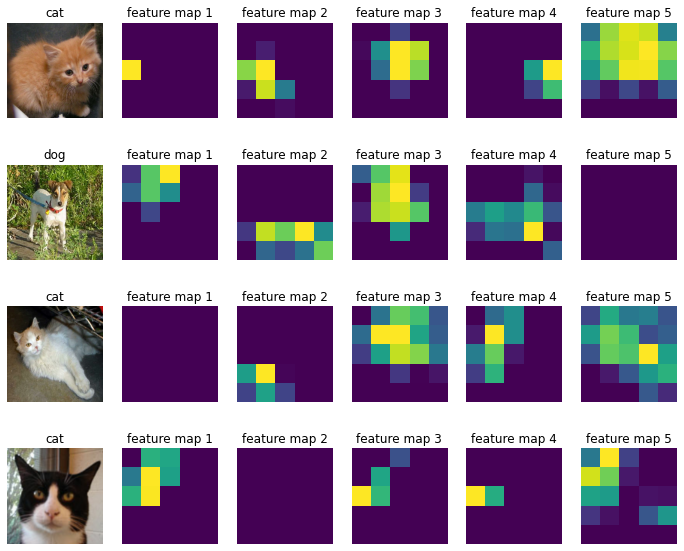

In [ ]:
n_img = 4
n_feat = 5
fig, axs = plt.subplots(n_img, n_feat+1)

for i in range(n_img):
    image = image_batch[i,...]
    label = label_batch[i]
    feature = feature_batch[i]
    ax = axs[i][0]
    ax.imshow(image.numpy().astype("uint8"))
    ax.axis('off')
    for j in range(1, n_feat+1):
        ax = axs[i][j]
        ax.imshow(feature[..., j])
        ax.axis('off')
        ax.set_title(f'feature map {j}')
    ax = axs[i][0]
    ax.set_title(class_names[label])
    ax.axis("off")
fig.set_size_inches((12,10))

## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1, name='output_layer')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Building the model
Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [ ]:
tf.random.set_seed(42)
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.save_weights('init.h5')

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0   

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### Train the model
Our model starts with a performance close to that of a random classifier: an accuracy of 50% (remember we are doing binary classification).
After training for 10 epochs, you should see ~98% accuracy on the validation set.


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

146/146 [==============================] - 10s 56ms/step - loss: 0.9863 - accuracy: 0.3632


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.99
initial accuracy: 0.36


In [ ]:
model.load_weights('init.h5')
out = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
437/437 [==============================] - 40s 81ms/step - loss: 0.4815 - accuracy: 0.7461 - val_loss: 0.1860 - val_accuracy: 0.9235
Epoch 2/10
437/437 [==============================] - 31s 70ms/step - loss: 0.2184 - accuracy: 0.9073 - val_loss: 0.1155 - val_accuracy: 0.9579
Epoch 3/10
437/437 [==============================] - 31s 71ms/step - loss: 0.1755 - accuracy: 0.9249 - val_loss: 0.0923 - val_accuracy: 0.9658
Epoch 4/10
437/437 [==============================] - 31s 70ms/step - loss: 0.1578 - accuracy: 0.9341 - val_loss: 0.0808 - val_accuracy: 0.9721
Epoch 5/10
437/437 [==============================] - 31s 71ms/step - loss: 0.1406 - accuracy: 0.9411 - val_loss: 0.0740 - val_accuracy: 0.9744
Epoch 6/10
437/437 [==============================] - 31s 72ms/step - loss: 0.1376 - accuracy: 0.9430 - val_loss: 0.0687 - val_accuracy: 0.9755
Epoch 7/10
437/437 [==============================] - 31s 71ms/step - loss: 0.1281 - accuracy: 0.9467 - val_loss: 0.0659 - val_accuracy:

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

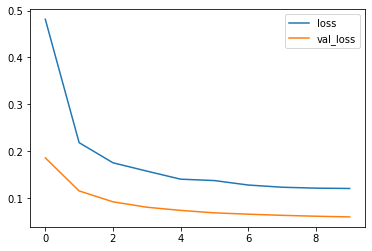

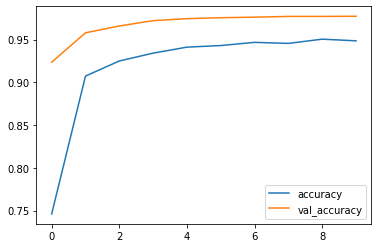

In [ ]:

df = pd.DataFrame(out.history)
df.plot(y=['loss', 'val_loss'])
df.plot(y=['accuracy', 'val_accuracy'])

Note: It can happen that the validation metrics be  better than the training metrics on these learning curves, which is counterintutitive. The main explanation factor is that layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training (they are implementing implicit regularization). They are turned off when calculating validation loss which is thus do not impacted by them.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

Since we want to go a bit slower, we will refrain from using the Adam optimizer (which is acombination of RMSprop and Momentum) and use RMSprop alone.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0   

In [ ]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

out_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=out.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
437/437 [==============================] - 49s 99ms/step - loss: 0.1097 - accuracy: 0.9555 - val_loss: 0.0429 - val_accuracy: 0.9865
Epoch 11/20
437/437 [==============================] - 42s 96ms/step - loss: 0.0929 - accuracy: 0.9635 - val_loss: 0.0586 - val_accuracy: 0.9802
Epoch 12/20
437/437 [==============================] - 42s 97ms/step - loss: 0.0796 - accuracy: 0.9683 - val_loss: 0.0408 - val_accuracy: 0.9841
Epoch 13/20
437/437 [==============================] - 42s 95ms/step - loss: 0.0733 - accuracy: 0.9709 - val_loss: 0.0392 - val_accuracy: 0.9865
Epoch 14/20
437/437 [==============================] - 42s 96ms/step - loss: 0.0718 - accuracy: 0.9703 - val_loss: 0.0777 - val_accuracy: 0.9766
Epoch 15/20
437/437 [==============================] - 46s 105ms/step - loss: 0.0634 - accuracy: 0.9753 - val_loss: 0.0557 - val_accuracy: 0.9822
Epoch 16/20
437/437 [==============================] - 42s 97ms/step - loss: 0.0591 - accuracy: 0.9777 - val_loss: 0.0374 - val_a

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

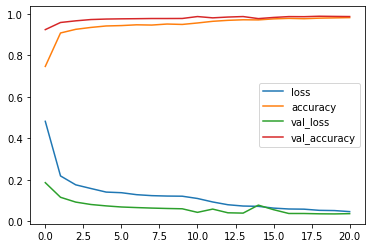

In [ ]:
full_history = pd.concat([df,pd.DataFrame(out_fine.history)], ignore_index=True)
full_history.plot()

NameError: ignored

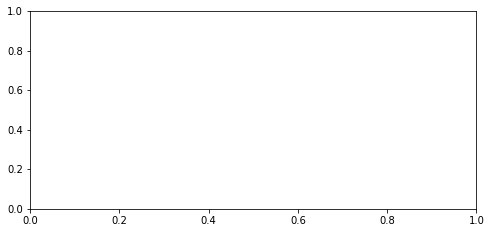

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

And now you are all set to use this model to predict if your pet is a cat or dog.

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.softmax(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy().round(2))
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
